In [1]:
#To make Figure 4 in 3-D CMZ Paper I
# 
#  Create d Mass / d longitude plots for the column density and temperature
# Observations only
# code pulled from kk16_comparison.ipynb which also compares with simulations
# Trying to simplify - since not sure how / if simulations will be included now.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.patches as patches
#import aplpy
#from pylab import figure, cm
#from matplotlib.colors import LogNorm
#from scipy.interpolate import griddata

In [3]:
#path='/Users/battersby/Dropbox/Work/higal_cmz/nh2_pdfs/FINAL_DATA_files_for_release/'
# stupid f-ing update ahhhh
path='/Users/cab16109/Dropbox/Work/higal_cmz/PAPER/FINAL_DATA_files_for_release/'
fig_path = '/Users/cab16109/Dropbox/Work/higal_cmz/PAPER/ALL_figures/'

In [4]:
# Function to convert column density to mass, with assumptions
def column_to_mass(data, header):
    # Convert from column density [cm^-2] to mass [solar masses]
    # Mass per pixel = column density per pixel [molecules cm^-2] * pixel area [cm^2] * mu * mh [kg] * 1/Msun [kg] = [Msun] 

    mu = 2.8 # Kauffman et al. 2008 appendix (mean molecular weight of molecular gas)
    mh = 1.67e-27 # kg
    msun = 1.99e30 #kg
    distance = 8150 #pc Reid 2019 udpated
    dcm = distance*3.086e18 # distance in cm

    # Get pixel area in square centimeter
    pixx_cm = dcm*(np.absolute(header['CDELT1'])*3600./206265) # distance in cm * angle in radians
    pixy_cm = dcm*(np.absolute(header['CDELT2'])*3600./206265)
    pix_area_cm2 = pixx_cm*pixy_cm

    #gets confused if you try to do it all in one step since numbers BIG, so separate out constant factors.
    column_to_mass_factor = (pix_area_cm2 * mu * mh) / msun
    mass = data * column_to_mass_factor
    
    return mass
    

In [5]:
# Read in data, create longitude and latitude arrays, convert to mass, then mass per longitude bin
# Do for inner 40 with BG, then without BG, then inner 7 degrees

### Full inner 40 degrees with BG ### 
hdulist = fits.open(path+'higalcmz_WITH_BG_column_density_inner40deg.fits')[0]
data = hdulist.data
h = hdulist.header

# Generate longitude and latitude arrays - inner 40 deg, used for both with and without BG
xdim=np.arange(data.shape[1])
hlonfull40=(xdim-h['crpix1'])*h['cdelt1']+h['crval1']
ydim=np.arange(data.shape[0])
hlatfull40=(ydim-h['crpix2'])*h['cdelt2']+h['crval2']

# Convert column density to mass:
hmassfull40wbg = column_to_mass(data, h)
print('Total Mass, Full 40 with background', (np.nansum(hmassfull40wbg, axis=(0,1))/1e7), '10^7 Msun')

# Get dM/dl, Mass per degree longitude
# original unit is mass per bin, now multiply by number of bins per degree to get Mass per degree longitude
num_deg = np.max(hlonfull40)-np.min(hlonfull40) # number of degrees in the image
bins_per_deg = np.nansum(hmassfull40wbg, axis=0).size / num_deg # number of "bins" (aka pixels) in longitude
dhmassdlfull40wbg = np.nansum(hmassfull40wbg, axis=0)*bins_per_deg # dmdl


### Full inner 40 degrees NO BG (regular), source only ### 
hdulist = fits.open(path+'higalcmz_column_density_source_only_inner40deg.fits')[0]
data = hdulist.data
h = hdulist.header

# Convert column density to mass:
hmassfull40 = column_to_mass(data, h)
print('Total Mass, Full 40 no background', (np.nansum(hmassfull40, axis=(0,1))/1e7), '10^7 Msun')

# Get dM/dl, Mass per degree longitude
# original unit is mass per bin, now multiply by number of bins per degree to get Mass per degree longitude
num_deg = np.max(hlonfull40)-np.min(hlonfull40) # number of degrees in the image
bins_per_deg = np.nansum(hmassfull40, axis=0).size / num_deg # number of "bins" (aka pixels) in longitude
dhmassdlfull40 = np.nansum(hmassfull40, axis=0)*bins_per_deg # dmdl


### Inner 7 degrees NO BG - source only ### 
hdulist = fits.open(path+'higalcmz_column_density_source_only_inner7deg.fits')[0]
data = hdulist.data
h = hdulist.header

# Generate longitude and latitude arrays - inner 40 deg, used for both with and without BG
xdim=np.arange(data.shape[1])
hlon=(xdim-h['crpix1'])*h['cdelt1']+h['crval1']
ydim=np.arange(data.shape[0])
hlat=(ydim-h['crpix2'])*h['cdelt2']+h['crval2']

# Convert column density to mass:
hmass = column_to_mass(data, h)
print('Total Mass, Full 40 with background', (np.nansum(hmass, axis=(0,1))/1e7), '10^7 Msun')

# Get dM/dl, Mass per degree longitude
# original unit is mass per bin, now multiply by number of bins per degree to get Mass per degree longitude
num_deg = np.max(hlon)-np.min(hlon) # number of degrees in the image
bins_per_deg = np.nansum(hmass, axis=0).size / num_deg # number of "bins" (aka pixels) in longitude
dhmassdl = np.nansum(hmass, axis=0)*bins_per_deg # dmdl


Total Mass, Full 40 with background 41.1815392 10^7 Msun
Total Mass, Full 40 no background 4.8703564 10^7 Msun
Total Mass, Full 40 with background 2.855917 10^7 Msun


In [6]:
# Read in temperature data

# Inner 7deg only
hdu = fits.open(path+'higalcmz_temperature_source_only_inner7deg.fits')[0]
htemp = hdu.data
h = hdu.header

# Grab only values about a column density of 1e22 (???)
column = fits.open(path+'higalcmz_column_density_source_only_inner7deg.fits')[0].data
htemp[np.where(column < 1e22)] = np.nan
#htemp[np.where(column >=1e22)] = htemp

#Flatten over longitude
htemp_lon=np.nanmedian(htemp,axis=0) #temp vs. longitude



# Inner 40deg
hdu = fits.open(path+'higalcmz_temperature_source_only_inner40deg.fits')[0]
htemp = hdu.data
h = hdu.header

# Grab only values about a column density of 1e22 (???)
column = fits.open(path+'higalcmz_column_density_source_only_inner40deg.fits')[0].data
htemp[np.where(column < 1e22)] = np.nan
#htemp[np.where(column >=1e22)] = htemp

#Flatten over longitude
htemp_lon40=np.nanmedian(htemp,axis=0) #temp vs. longitude


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


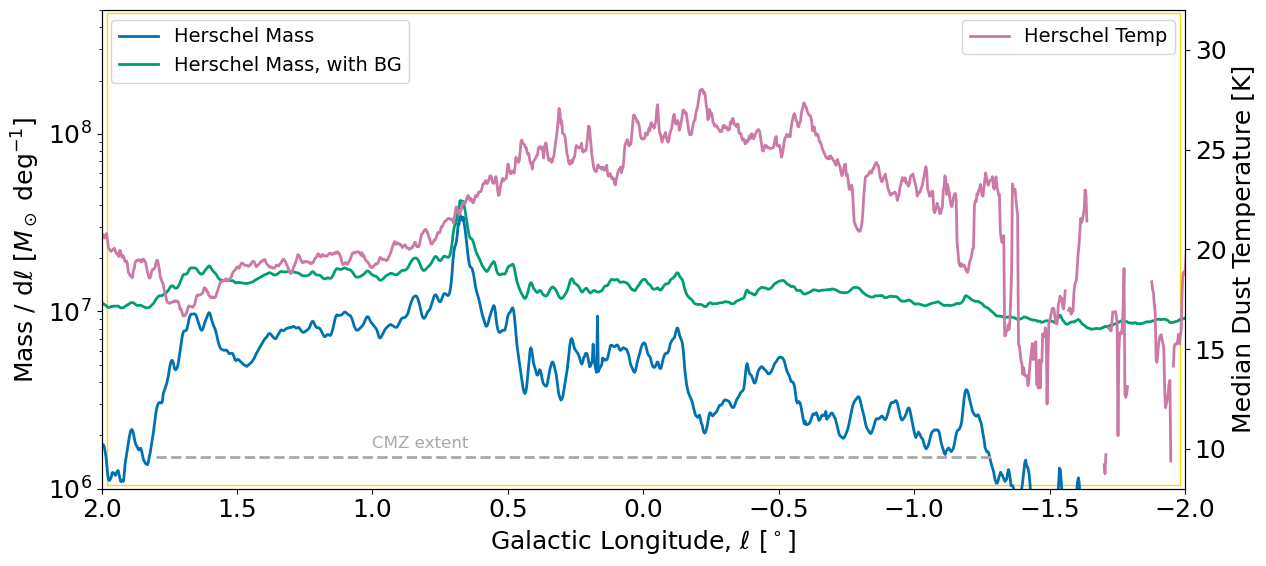

In [46]:
# Make dmdl plot of inner 7 degrees
#%matplotlib nbagg
#%matplotlib widget
#plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 18}) #set fontsize

fig, ax1 = plt.subplots(figsize=(13,6))

# Axis 1 - column density
# Inner 7 degree, source only
#ax1.plot(hlon, dhmassdl, lw=2, label=r'Herschel Mass')
# full40 data, no BG subtracted
#ax1.plot(hlonfull40, dhmassdlfull40wbg, lw=2, label=r'Herschel Mass, with BG')

ax1.plot(hlonfull40, dhmassdlfull40, lw=2, label=r'Herschel Mass')
ax1.plot(hlonfull40, dhmassdlfull40wbg, lw=2, label=r'Herschel Mass, with BG')


ax1.set_xlabel(r'Galactic Longitude, $\ell$ [$^\circ$]')
#ax1.set_ylabel('$dM/dl$ [$M_\odot$ deg$^{-1}$]')
ax1.set_ylabel('Mass $/$ d$\ell$ [$M_\odot$ deg$^{-1}$]')
ax1.set_ylim([1e5,5e7])
#ax1.set_xlim([-1.5,1.5])
ax1.set_ylim([1e6,5e8])
ax1.set_yscale('log')


#PLOT CMZ EXTENT:
# first define CMZ extent
cmzlev=1.5e6 #3*sigma, sigma ~5e5 Msun/deg by eye
cmz_l1 = 1.8
cmz_l2 = -1.3
hlon_cmz = np.linspace(cmz_l1, cmz_l2, 100)
dmdl_cmz = np.zeros(100)+cmzlev
# then plot
plt.plot(hlon_cmz, dmdl_cmz, lw=2, ls='--', color='darkgray')
plt.text(1.0, 1.7e6, "CMZ extent", fontsize=12, color='darkgray')


# Axis 2 - temperature
ax2 = ax1.twinx()
ax2.plot([0,0],[0,0], lw=2)

ax2.plot(hlon,htemp_lon*0)
ax2.plot(hlon,htemp_lon*0)
ax2.plot(hlon, htemp_lon, lw=2, label=r'Herschel Temp')
ax2.set_ylabel('Median Dust Temperature [K]')
ax2.set_xlabel(r'Galactic Longitude, $\ell$ [$^\circ$]')
#ax2.set_ylim([0,35])\
ax2.set_ylim([8,32])
#ax2.set_xlim([-1.6,1.6])
ax2.set_xlim([-2,2])
plt.locator_params(axis='y', nbins=5)

#Legend
legend = ax1.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')
legend = ax2.legend(loc='upper right', shadow=False, fontsize=14)#'x-large')

# Finishing touches
plt.gca().invert_xaxis()
plt.gcf().subplots_adjust(bottom=0.15) # make room for x-axis
fig.tight_layout()


#whole field rectangle
rect = patches.Rectangle((1.98, 1.05e6), -3.96, 4.8e8, linewidth=1, edgecolor='gold', facecolor='none')
ax1.add_patch(rect)

# Save as PDF
plt.savefig(fig_path+'Column_temp_vs_longitude_inner3deg.pdf', 
            format='pdf', dpi=1000)

plt.show()



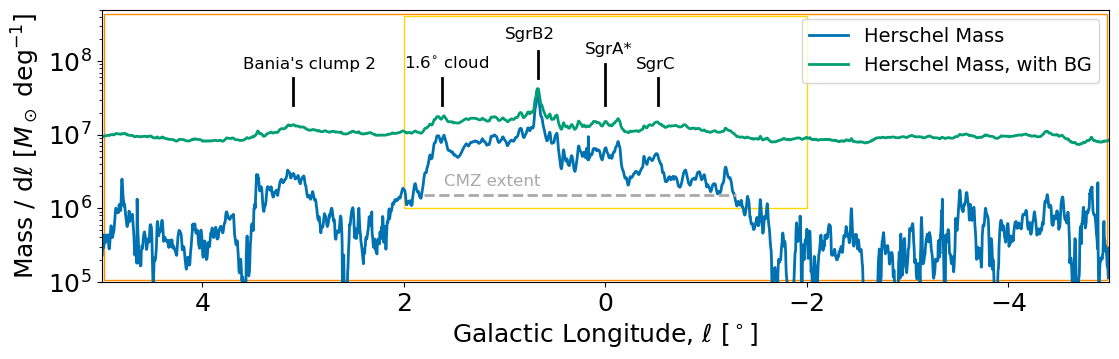

In [47]:
# Plot column densiites over inner 10 degrees (looks better without temperature as well)

#Plot style
#%matplotlib widget
#plt.style.use('battersbot-colorblind')
#plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1,figsize=(13,4))
ax = fig.gca()
ax.set_yscale('log')

# Plot data
plt.plot(hlonfull40, dhmassdlfull40, lw=2, label=r'Herschel Mass')
plt.plot(hlonfull40, dhmassdlfull40wbg, lw=2, label=r'Herschel Mass, with BG')

#plot cmz extent (defined above):
plt.plot(hlon_cmz, dmdl_cmz, lw=2, ls='--', color='darkgray')
plt.text(1.6, 2e6, "CMZ extent", fontsize=12, color='darkgray')


#plt.ylabel('$dM/dl$ [$M_\odot deg^{-1}$]')
plt.ylabel('Mass $/$ d$\ell$ [$M_\odot$ deg$^{-1}$]')
plt.xlabel(r'Galactic Longitude, $\ell$ [$^\circ$]')


ax.set_ylim([1e5,5e8])
ax.set_xlim([-5.0,5.0])


#add various markers
#plt.markers.markerstyle(marker='vline')
plt.text(3.6, 8e7, "Bania's clump 2", fontsize=12)
plt.axvline(x=3.1, ymin=0.65, ymax=0.75, color='black',lw=2)

plt.text(1, 2e8, "SgrB2", fontsize=12)
plt.axvline(x=0.67, ymin=0.75, ymax=0.85, color='black',lw=2)

plt.text(0.2, 1.25e8, "SgrA*", fontsize=12)
plt.axvline(x=0.0, ymin=0.65, ymax=0.8, color='black',lw=2)

plt.text(-0.3, 8e7, "SgrC", fontsize=12)
plt.axvline(x=-0.52, ymin=0.65, ymax=0.75, color='black',lw=2)

plt.text(2, 8e7, "1.6$^{\circ}$ cloud", fontsize=12)
plt.axvline(x=1.62, ymin=0.65, ymax=0.75, color='black',lw=2)

# Finishing touches
plt.gca().invert_xaxis()
plt.gcf().subplots_adjust(bottom=0.2) # make room for x-axis
legend = plt.legend(loc='upper right', shadow=False, fontsize=14)#'x-large')

# add rectangle for showing next zoom plot:
# Create a Rectangle patch
#whole field rectangle
rect = patches.Rectangle((4.98, 1.05e5), -9.96, 4.4e8, linewidth=1, edgecolor='darkorange', facecolor='none')
ax.add_patch(rect)
#zoom rectangle
rect = patches.Rectangle((2, 1e6), -4, 4.1e8, linewidth=1, edgecolor='gold', facecolor='none')
ax.add_patch(rect)


# Save as PDF
plt.savefig(fig_path+'Column_vs_longitude_inner10deg.pdf', 
            format='pdf', dpi=1000)


plt.show()


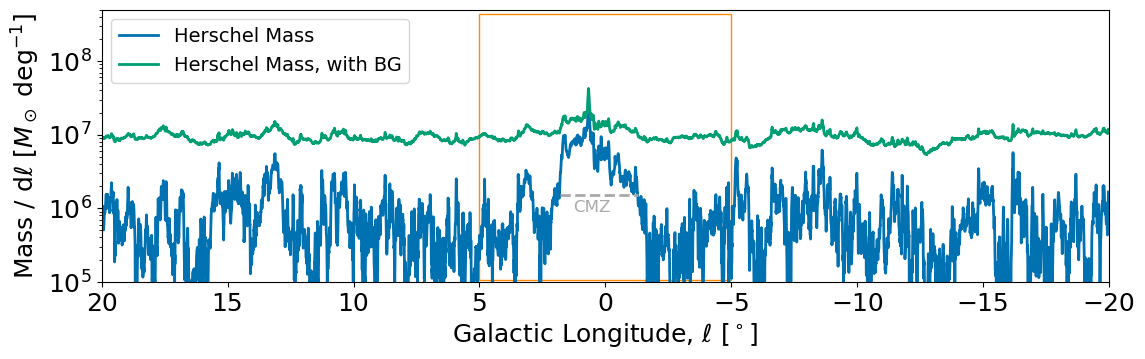

In [48]:
# Plot column densiites over inner 40 degrees (looks better without temperature as well)

#Plot style
#%matplotlib nbagg
#plt.style.use('battersbot-colorblind')
#plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1,figsize=(13,4))
ax = fig.gca()
ax.set_yscale('log')

# Plot data
plt.plot(hlonfull40, dhmassdlfull40, lw=2, label=r'Herschel Mass')
plt.plot(hlonfull40, dhmassdlfull40wbg, lw=2, label=r'Herschel Mass, with BG')

#plt.ylabel('$dM/dl$ [$M_\odot deg^{-1}$]')
plt.ylabel('Mass $/$ d$\ell$ [$M_\odot$ deg$^{-1}$]')
plt.xlabel(r'Galactic Longitude, $\ell$ [$^\circ$]')
ax.set_ylim([1e5,5e8])
ax.set_xlim([-20.0,20.0])

#plot cmz extent (defined above):
plt.plot(hlon_cmz, dmdl_cmz, lw=2, ls='--', color='darkgray')
plt.text(1.3, 9e5, "CMZ", fontsize=12, color='darkgray')


# Final touches
plt.gca().invert_xaxis()
plt.gcf().subplots_adjust(bottom=0.2) # make room for x-axis

# add rectangle for showing next zoom plot:
# Create a Rectangle patch
rect = patches.Rectangle((5, 1.05e5), -10, 4.4e8, linewidth=1, edgecolor='darkorange', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

# Legend
legend = plt.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')

# Save as PDF
plt.savefig(fig_path+'Column_vs_longitude_inner40deg.pdf', 
            format='pdf', dpi=1000)

plt.show()

In [ ]:


#### EEHHHHH, Use previous cell, better without temperature IMHO
### can delete probably, saving for posterity / just in case??


# Make dmdl plot of inner 40 degrees 
%matplotlib nbagg
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 18}) #set fontsize

fig, ax1 = plt.subplots(figsize=(13,6))

# Axis 1 - column density
# Inner 40 degrees, source only
ax1.plot(hlonfull40, dhmassdlfull40, lw=2, label=r'Herschel Mass')
# full40 data, no BG subtracted
ax1.plot(hlonfull40, dhmassdlfull40wbg, lw=2, label=r'Herschel Mass, with BG')

ax1.set_xlabel(r'Galactic Longitude [$^\circ$]')
ax1.set_ylabel('$dM/dl$ [$M_\odot deg^{-1}$]')
ax1.set_yscale('log')
ax1.set_ylim([1e5,5e8])
ax1.set_xlim([-20.0,20.0])

# Axis 2 - temperature
ax2 = ax1.twinx()
ax2.plot([0,0],[0,0], lw=2)

ax2.plot(hlonfull40,htemp_lon40*0)
ax2.plot(hlonfull40,htemp_lon40*0)
ax2.plot(hlonfull40, htemp_lon40, lw=2, label=r'Herschel Temp')
ax2.set_ylabel('Median Dust Temperature [K]')
ax2.set_xlabel(r'Galactic Longitude [$^\circ$]')
ax2.set_ylim([0,35])
ax2.set_xlim([-20.0, 20.0])

#Legend
legend = ax1.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')
legend = ax2.legend(loc='upper right', shadow=False, fontsize=14)#'x-large')

# Finishing touches
plt.gca().invert_xaxis()
plt.gcf().subplots_adjust(bottom=0.15) # make room for x-axis
fig.tight_layout()
plt.show()

# Save as PDF
plt.savefig('/Users/battersby/Dropbox/Work/higal_cmz/PAPER/figures/Column_temp_vs_longitude_inner40deg.pdf', 
            format='pdf', dpi=1000)

